In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUS:  1


In [3]:
df_train = pd.read_csv("data/sign_mnist_train/sign_mnist_train.csv")
df_test = pd.read_csv("data/sign_mnist_test/sign_mnist_test.csv")

In [4]:
df_train.shape

(27455, 785)

Text(0, 0.5, 'Occurences')

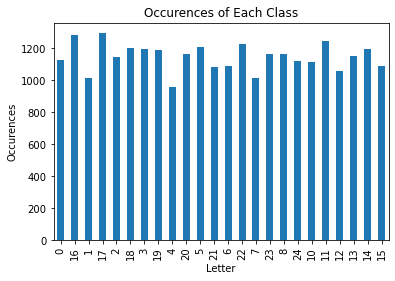

In [11]:
df_train['label'].value_counts(sort=False).plot(kind='bar')
plt.title('Occurences of Each Class')
plt.xlabel('Letter')
plt.ylabel('Occurences')

In [12]:
#separate labels
y_train = df_train['label']
y_test = df_test['label']

#convert training and test data into 3D np arrays
X_train = df_train.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1)
X_test = df_test.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1)

#Make validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, shuffle=True)

In [13]:
#Normalize grayscale
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

In [14]:
#convert labels to binary form
label_bin = LabelBinarizer()
y_train = label_bin.fit_transform(y_train)
y_valid = label_bin.fit_transform(y_valid)

In [15]:
#Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=False,
    vertical_flip=False)

data_gen.fit(X_train)

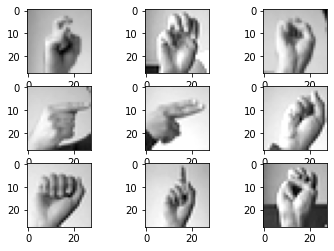

In [16]:
#Visualize preprocessed images
fig, axes = plt.subplots(3, 3)
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')

In [17]:
#Build CNN model

model = Sequential()
model.add(Conv2D(32, (3,3), strides=1, padding='same',
                 activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Conv2D(64, (3,3), strides=1, padding='same',
                 activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=24, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 24)               

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(data_gen.flow(X_train, y_train, batch_size=128),
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    verbose=2)

Epoch 1/20
 - 5s - loss: 0.5587 - accuracy: 0.8254 - val_loss: 0.2192 - val_accuracy: 0.9335
Epoch 2/20
 - 5s - loss: 0.3624 - accuracy: 0.8915 - val_loss: 0.1688 - val_accuracy: 0.9354
Epoch 3/20
 - 5s - loss: 0.2496 - accuracy: 0.9255 - val_loss: 0.0665 - val_accuracy: 0.9893
Epoch 4/20
 - 5s - loss: 0.1813 - accuracy: 0.9459 - val_loss: 0.0343 - val_accuracy: 0.9961
Epoch 5/20
 - 5s - loss: 0.1316 - accuracy: 0.9631 - val_loss: 0.0294 - val_accuracy: 0.9939
Epoch 6/20
 - 5s - loss: 0.1010 - accuracy: 0.9723 - val_loss: 0.0173 - val_accuracy: 0.9983
Epoch 7/20
 - 5s - loss: 0.0785 - accuracy: 0.9787 - val_loss: 0.0117 - val_accuracy: 0.9993
Epoch 8/20
 - 5s - loss: 0.0681 - accuracy: 0.9817 - val_loss: 0.0103 - val_accuracy: 0.9985
Epoch 9/20
 - 5s - loss: 0.0539 - accuracy: 0.9857 - val_loss: 0.0113 - val_accuracy: 0.9971
Epoch 10/20
 - 5s - loss: 0.0431 - accuracy: 0.9889 - val_loss: 0.0135 - val_accuracy: 0.9971
Epoch 11/20
 - 8s - loss: 0.0354 - accuracy: 0.9911 - val_loss: 0.011

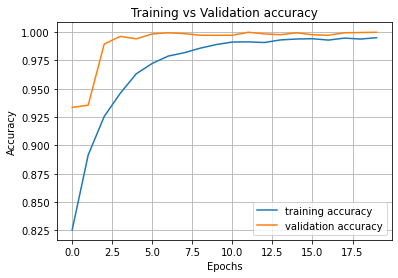

In [21]:
plt.plot(history.epoch, history.history['accuracy'], label='training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title('Training vs Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()

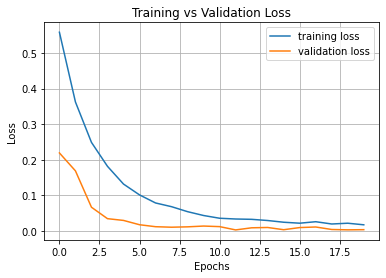

In [22]:
plt.plot(history.epoch, history.history['loss'], label='training loss')
plt.plot(history.epoch, history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

In [23]:
#predict test data
predictions = model.predict_classes(X_test)

#since letter #9 is missing from dataset, we move everything forward by 1
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.98      0.99       432
           2       1.00      0.99      1.00       310
           3       1.00      1.00      1.00       245
           4       0.96      1.00      0.98       498
           5       0.99      1.00      1.00       247
           6       1.00      0.94      0.97       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       0.99      1.00      1.00       331
          11       1.00      0.98      0.99       209
          12       1.00      0.99      1.00       394
          13       0.99      1.00      0.99       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.97      1.00      0.98       144
          18       1.00    

In [26]:
model.save('models/model_20.h5')